# Neural的调度能力
限制速度幅度的情况下，同样的信息输入，同样的控制结构。
自适应的NNs总是比固定比例的控制器更好，同时damped effect更好。

Starting training...
Epoch [10/2000], Loss: 216592.6406
Epoch [20/2000], Loss: 86827.0078
Epoch [30/2000], Loss: 44056.7422
Epoch [40/2000], Loss: 33502.7656
Epoch [50/2000], Loss: 23335.1094
Epoch [60/2000], Loss: 12134.4883
Epoch [70/2000], Loss: 10994.5742
Epoch [80/2000], Loss: 10080.8145
Epoch [90/2000], Loss: 9374.8828
Epoch [100/2000], Loss: 8952.3447
Epoch [110/2000], Loss: 8569.1436
Epoch [120/2000], Loss: 8238.5791
Epoch [130/2000], Loss: 7926.4082
Epoch [140/2000], Loss: 7628.1831
Epoch [150/2000], Loss: 7340.2925
Epoch [160/2000], Loss: 7066.5923
Epoch [170/2000], Loss: 6806.8120
Epoch [180/2000], Loss: 6561.2100
Epoch [190/2000], Loss: 6327.2500
Epoch [200/2000], Loss: 6106.7598
Epoch [210/2000], Loss: 5900.8970
Epoch [220/2000], Loss: 5707.8262
Epoch [230/2000], Loss: 5525.6514
Epoch [240/2000], Loss: 5355.0254
Epoch [250/2000], Loss: 5193.6792
Epoch [260/2000], Loss: 5020.6992
Epoch [270/2000], Loss: 4880.2837
Epoch [280/2000], Loss: 4752.4385
Epoch [290/2000], Loss: 464

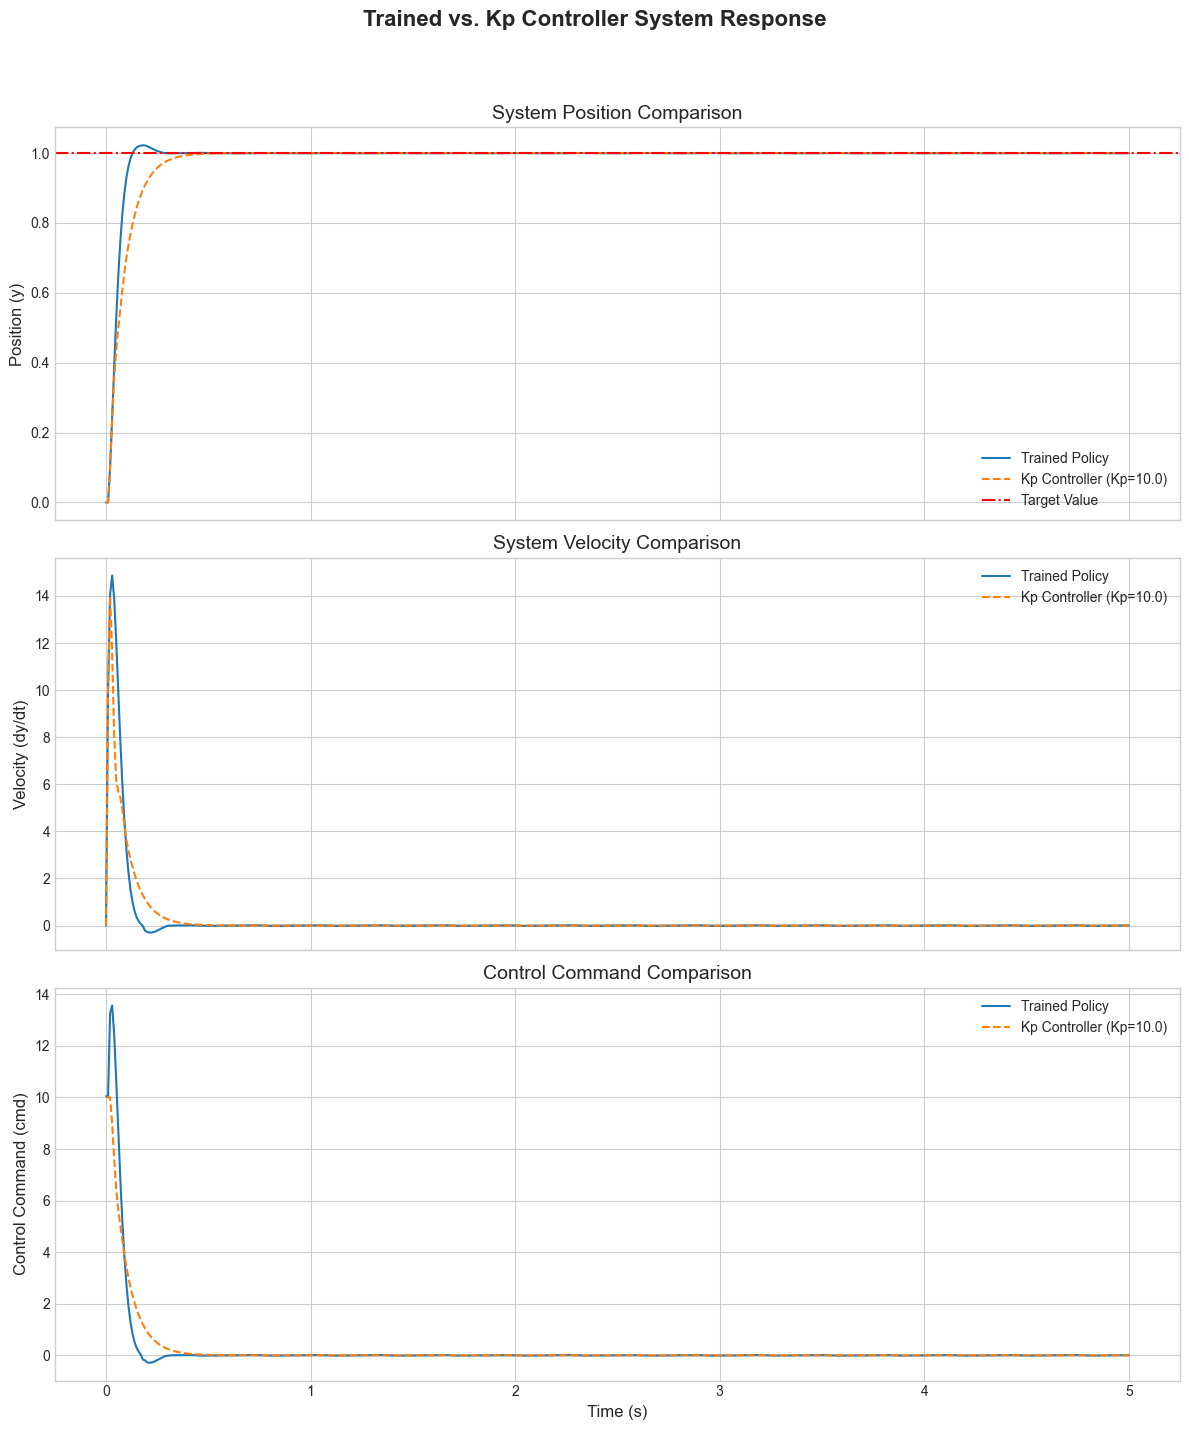

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


# Define the ThirdOrderSystem as an nn.Module
class ThirdOrderSystem(nn.Module):
    def __init__(self, zeta, omega_n, sim_dt=0.01):
        super(ThirdOrderSystem, self).__init__()
        self.zeta = torch.tensor(zeta, dtype=torch.float32)
        self.omega_n = torch.tensor(omega_n, dtype=torch.float32)
        self.sim_dt = sim_dt
        self.state = torch.zeros(3)

    def simulate(self, cmd):
        angle = self.state[0]
        angle_next = angle + self.sim_dt * self.state[1]
        y, dy_dt = self.state[1], self.state[2]

        dy_dt2 = (
            -(self.omega_n**2) * y
            - 2 * self.zeta * self.omega_n * dy_dt
            + self.omega_n**2 * cmd
        )

        y_next = y + dy_dt * self.sim_dt
        dy_dt_next = dy_dt + dy_dt2 * self.sim_dt
        self.state = torch.stack([angle_next, y_next, dy_dt_next])
        return self.state


# Define the ControlPolicy as an nn.Module
class ControlPolicy(nn.Module):
    def __init__(self):
        super(ControlPolicy, self).__init__()
        self.control_net = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
        )

    def forward(self, target, current_state):
        error = target - current_state[0]
        velocity = current_state[1]
        # Input to the network: position error and velocity
        net_input = torch.stack([error, velocity])
        cmd = self.control_net(net_input)
        return cmd.squeeze()


# Simulation parameters
zeta_val = 0.8
omega_n_val = 100.0
dt = 0.1
target_value = torch.tensor(1.0)

# Instantiate models and optimizer
system = ThirdOrderSystem(zeta=zeta_val, omega_n=omega_n_val)
policy = ControlPolicy()
optimizer = torch.optim.Adam(policy.parameters(), lr=0.01)

# Training loop with BPTT
num_epochs = 2000
rho1 = 1000.0  # Weight for position error
rho2 = 100.0  # Weight for velocity squared
velocity_limit = 14.0  # Velocity limit for penalty
print("Starting training...")
for epoch in range(num_epochs):
    # Reset for each epoch
    system.state = torch.zeros(3)
    total_loss = 0

    # BPTT loop
    for i in range(200):
        # Get control command and simulate
        cmd = policy(target_value, system.state)
        system.simulate(cmd)

        # Only penalize position error in the later stage of the trajectory
        error_y = (target_value - system.state[0]) ** 2
        total_loss += rho1 * error_y

        # Penalize velocity if it exceeds the limit
        over_limit = torch.relu(torch.abs(system.state[1]) - velocity_limit)
        loss = rho2 * over_limit**2
        total_loss += loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss.item():.4f}")

print("Training finished.")

# ---
# Simulation and Plotting after Training
# ---

print("Simulating and plotting the final response...")

# Re-instantiate the systems to start from a clean state
system_final_trained = ThirdOrderSystem(zeta=zeta_val, omega_n=omega_n_val)
system_final_kp = ThirdOrderSystem(zeta=zeta_val, omega_n=omega_n_val)

# Prepare lists to store data for plotting
positions_trained, positions_kp = [], []
velocities_trained, velocities_kp = [], []
commands_trained, commands_kp = [], []
time_points = []
time_step = 0.01  # Use a smaller time step for a smoother plot
total_time = 5.0

# -----------------
# Kp controller parameters
kp_gain = 10.0  # You can adjust this Kp gain for a better response
# -----------------

current_time = 0.0
while current_time <= total_time:
    with torch.no_grad():
        # 1. Trained policy
        cmd_trained = policy(target_value, system_final_trained.state)

        # 2. Kp controller
        error_kp = target_value - system_final_kp.state[0]
        cmd_kp = kp_gain * error_kp

    # Simulate the system's response for both controllers
    system_final_trained.simulate(cmd_trained)
    system_final_kp.simulate(cmd_kp)

    # Record the data for plotting
    positions_trained.append(system_final_trained.state[0].item())
    positions_kp.append(system_final_kp.state[0].item())
    velocities_trained.append(system_final_trained.state[1].item())
    velocities_kp.append(system_final_kp.state[1].item())
    commands_trained.append(cmd_trained.item())
    commands_kp.append(cmd_kp.item())
    time_points.append(current_time)

    current_time += time_step

# Plotting the results
plt.style.use("seaborn-v0_8-whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
fig.suptitle(
    "Trained vs. Kp Controller System Response",
    fontsize=16,
    fontweight="bold",
)

# Subplot 1: Position
ax1.set_ylabel("Position (y)", fontsize=12)
ax1.plot(time_points, positions_trained, color="tab:blue", label="Trained Policy")
ax1.plot(
    time_points,
    positions_kp,
    color="tab:orange",
    linestyle="--",
    label=f"Kp Controller (Kp={kp_gain})",
)
ax1.axhline(y=target_value.item(), color="r", linestyle="-.", label="Target Value")
ax1.set_title("System Position Comparison", fontsize=14)
ax1.legend(loc="lower right")
ax1.grid(True)

# Subplot 2: Velocity
ax2.set_ylabel("Velocity (dy/dt)", fontsize=12)
ax2.plot(time_points, velocities_trained, color="tab:blue", label="Trained Policy")
ax2.plot(
    time_points,
    velocities_kp,
    color="tab:orange",
    linestyle="--",
    label=f"Kp Controller (Kp={kp_gain})",
)
ax2.set_title("System Velocity Comparison", fontsize=14)
ax2.legend(loc="upper right")
ax2.grid(True)

# Subplot 3: Control Command
ax3.set_xlabel("Time (s)", fontsize=12)
ax3.set_ylabel("Control Command (cmd)", fontsize=12)
ax3.plot(time_points, commands_trained, color="tab:blue", label="Trained Policy")
ax3.plot(
    time_points,
    commands_kp,
    color="tab:orange",
    linestyle="--",
    label=f"Kp Controller (Kp={kp_gain})",
)
ax3.set_title("Control Command Comparison", fontsize=14)
ax3.legend(loc="upper right")
ax3.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("third_order_system_comparison_full.png")
plt.show()

Train on noisy, test on idea

Starting training...
Epoch [10/500], Loss: 67951.6016
Epoch [20/500], Loss: 22025.8105
Epoch [30/500], Loss: 20447.6328
Epoch [40/500], Loss: 16918.1719
Epoch [50/500], Loss: 14028.1631
Epoch [60/500], Loss: 10760.5938
Epoch [70/500], Loss: 7395.6924
Epoch [80/500], Loss: 3535.1184
Epoch [90/500], Loss: 1132.1550
Epoch [100/500], Loss: 221.5120
Epoch [110/500], Loss: 48.7918
Epoch [120/500], Loss: 41.9289
Epoch [130/500], Loss: 21.8896
Epoch [140/500], Loss: 9.7225
Epoch [150/500], Loss: 6.8597
Epoch [160/500], Loss: 5.8759
Epoch [170/500], Loss: 4.9714
Epoch [180/500], Loss: 4.2666
Epoch [190/500], Loss: 3.7781
Epoch [200/500], Loss: 3.4069
Epoch [210/500], Loss: 3.1137
Epoch [220/500], Loss: 2.8586
Epoch [230/500], Loss: 2.6314
Epoch [240/500], Loss: 2.4523
Epoch [250/500], Loss: 2.2962
Epoch [260/500], Loss: 2.1506
Epoch [270/500], Loss: 2.0155
Epoch [280/500], Loss: 1.8900
Epoch [290/500], Loss: 1.7795
Epoch [300/500], Loss: 1.6925
Epoch [310/500], Loss: 1.6138
Epoch [320/500], Los

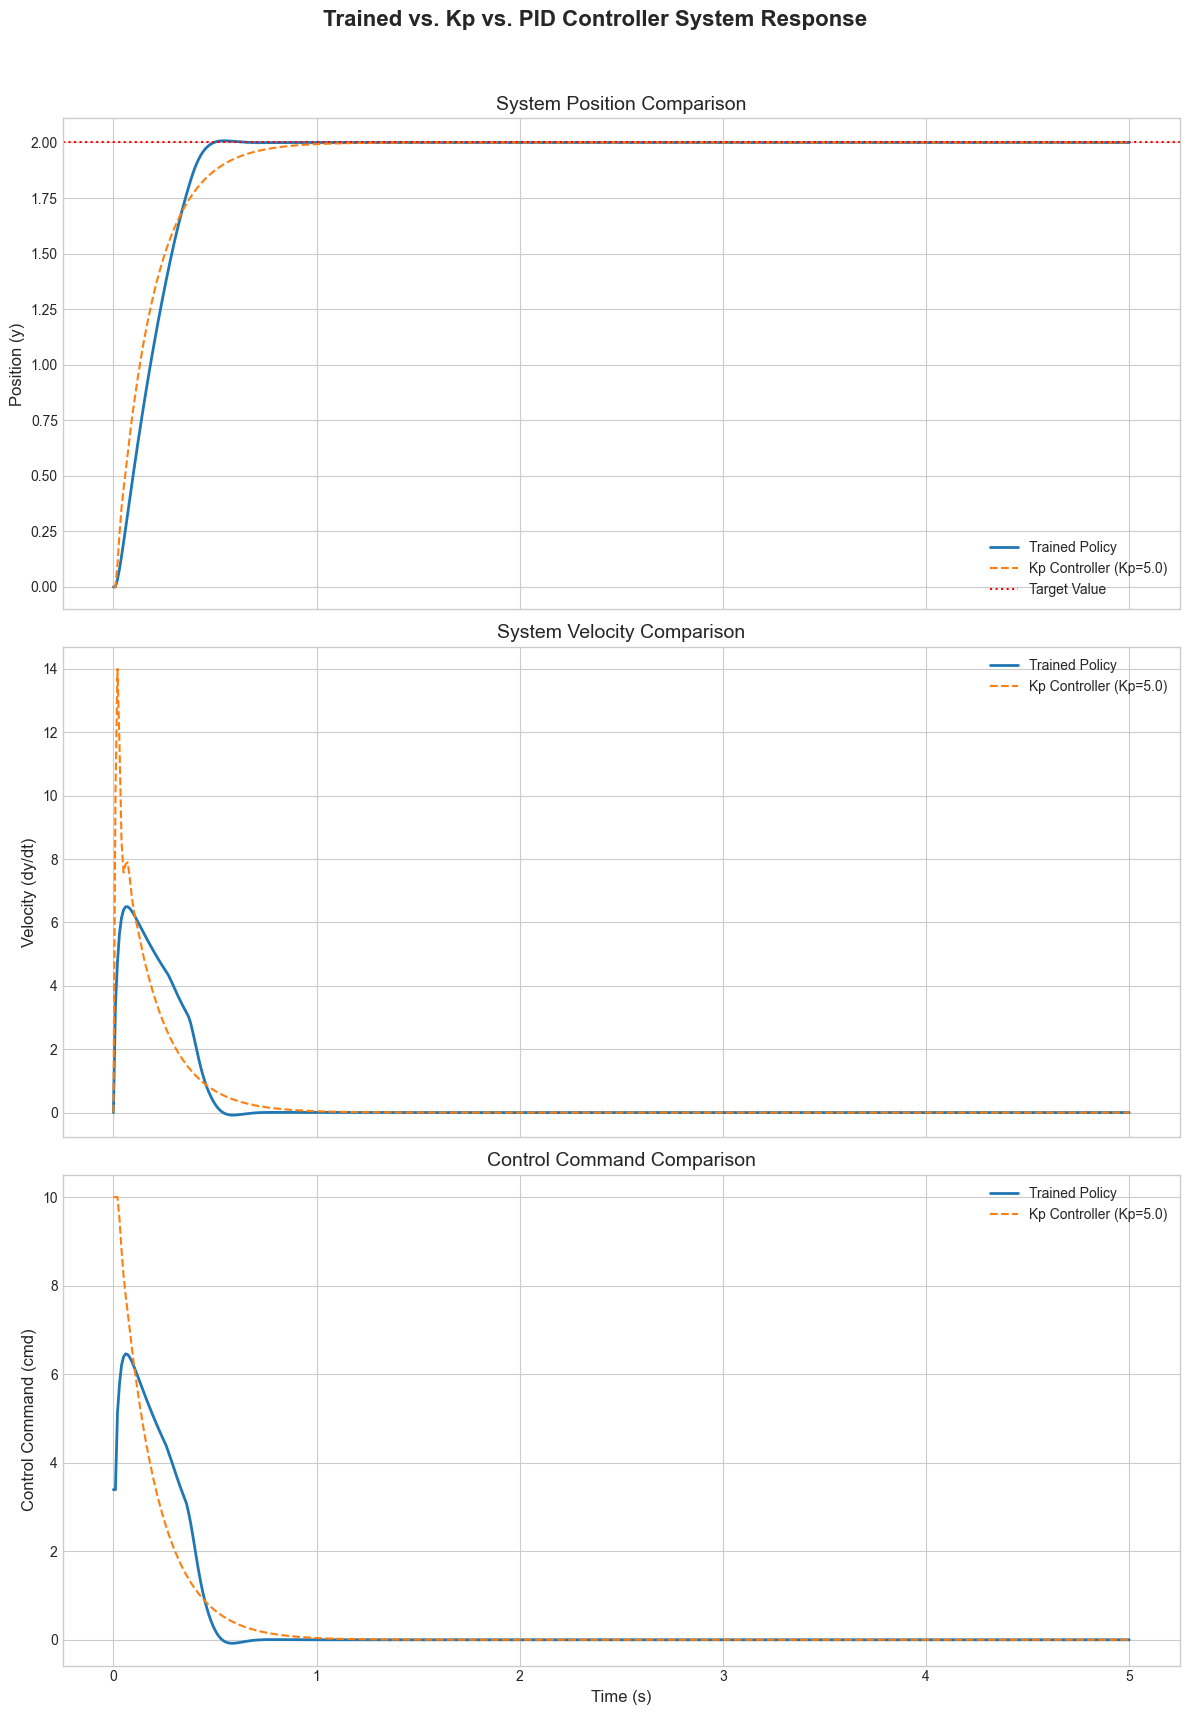

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR


# Define the ThirdOrderSystem as an nn.Module
class ThirdOrderSystem(nn.Module):
    def __init__(self, zeta, omega_n, noise_level: float = 1.0, sim_dt=0.01):
        super(ThirdOrderSystem, self).__init__()
        self.zeta = torch.tensor(zeta, dtype=torch.float32)
        self.omega_n = torch.tensor(omega_n, dtype=torch.float32)
        self.sim_dt = sim_dt
        # Detach the state to ensure it's treated as a leaf tensor in new graphs
        self.state = torch.zeros(3).detach()
        self.noise_level = noise_level

    def simulate(self, cmd):
        # Ensure cmd is a tensor
        if not isinstance(cmd, torch.Tensor):
            cmd = torch.tensor(cmd, dtype=torch.float32)

        # The state update logic should not be part of the graph being differentiated
        # in the training loop, so we can detach it.
        # This is especially important when re-using the class for simulation.
        current_state = self.state.detach()

        angle_next = current_state[0] + self.sim_dt * current_state[1]
        y, dy_dt = current_state[1], current_state[2]

        dy_dt2 = (
            -(self.omega_n**2) * y
            - 2 * self.zeta * self.omega_n * dy_dt
            + self.omega_n**2 * cmd
        )

        y_next = y + dy_dt * self.sim_dt + torch.randn(1).item() * self.noise_level
        dy_dt_next = dy_dt + dy_dt2 * self.sim_dt
        self.state = torch.stack([angle_next, y_next, dy_dt_next])
        return self.state


# Define the ControlPolicy as an nn.Module
class ControlPolicy(nn.Module):
    def __init__(self):
        super(ControlPolicy, self).__init__()
        self.control_net = nn.Sequential(
            nn.Linear(2, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 1),
        )

    def forward(self, target, current_state):
        error = target - current_state[0]
        velocity = current_state[1]
        # Input to the network: position error and velocity
        net_input = torch.stack([error, velocity])
        cmd = self.control_net(net_input)
        return cmd.squeeze()


# Simulation parameters
zeta_val = 0.8
omega_n_val = 100.0
target_value_train = torch.tensor(1.0)

# Instantiate models and optimizer
system = ThirdOrderSystem(zeta=zeta_val, omega_n=omega_n_val)
policy = ControlPolicy()
optimizer = torch.optim.Adam(policy.parameters(), lr=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=0.0001)
# Training loop with BPTT
num_epochs = 500
rho1 = 1000.0  # Weight for position error
rho2 = 10000.0  # Weight for velocity squared
velocity_limit = 5.0  # Velocity limit for penalty
print("Starting training...")
for epoch in range(num_epochs):
    # Reset for each epoch
    system.state = torch.zeros(3)
    total_loss = 0
    optimizer.zero_grad()  # Clear gradients at the start of the epoch

    # BPTT loop - build computation graph over the trajectory
    trajectory_states = []
    cmds = []

    # Forward pass to collect trajectory
    temp_system_state = system.state.clone().detach()
    for _ in range(200):
        cmd = policy(target_value_train, temp_system_state)
        # Use a temporary system for forward pass to keep the graph clean
        # The system state update itself is a part of the computation graph
        angle_next = temp_system_state[0] + system.sim_dt * temp_system_state[1]
        y, dy_dt = temp_system_state[1], temp_system_state[2]
        dy_dt2 = (
            -(system.omega_n**2) * y
            - 2 * system.zeta * system.omega_n * dy_dt
            + system.omega_n**2 * cmd
        )
        y_next = y + dy_dt * system.sim_dt
        dy_dt_next = dy_dt + dy_dt2 * system.sim_dt
        temp_system_state = torch.stack([angle_next, y_next, dy_dt_next])
        trajectory_states.append(temp_system_state)

    # Calculate loss over the trajectory
    for i, state in enumerate(trajectory_states):
        if i > 30:
            error_y = (target_value_train - state[0]) ** 2
            total_loss += rho1 * error_y
        over_limit = torch.relu(torch.abs(state[1]) - velocity_limit)
        loss = rho2 * over_limit**2
        total_loss += loss

    total_loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss.item():.4f}")

print("Training finished.")


# Simulation and Plotting after Training
print("Simulating and plotting the final response...")

# Re-instantiate the systems to start from a clean state
system_final_trained = ThirdOrderSystem(
    zeta=zeta_val, omega_n=omega_n_val, noise_level=0.0
)
system_final_kp = ThirdOrderSystem(zeta=zeta_val, omega_n=omega_n_val, noise_level=0.0)


# Prepare lists to store data for plotting
positions_trained, positions_kp = [], []
velocities_trained, velocities_kp = [], []
commands_trained, commands_kp = [], []
time_points = []
time_step = 0.01
total_time = 5.0

# ---
# Controller parameters for comparison
# ---
# Kp controller
kp_gain = 5.0


target_value_sim = torch.tensor(2.0)
current_time = 0.0
while current_time <= total_time:
    with torch.no_grad():
        # 1. Trained policy
        cmd_trained = policy(target_value_sim, system_final_trained.state)

        # 2. Kp controller
        error_kp = target_value_sim - system_final_kp.state[0]
        cmd_kp = kp_gain * error_kp

    # Simulate the system's response for all three controllers
    system_final_trained.simulate(cmd_trained)
    system_final_kp.simulate(cmd_kp)

    # Record the data for plotting
    positions_trained.append(system_final_trained.state[0].item())
    positions_kp.append(system_final_kp.state[0].item())

    velocities_trained.append(system_final_trained.state[1].item())
    velocities_kp.append(system_final_kp.state[1].item())

    commands_trained.append(cmd_trained.item())
    commands_kp.append(cmd_kp.item())

    time_points.append(current_time)
    current_time += time_step

# Plotting the results
plt.style.use("seaborn-v0_8-whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
fig.suptitle(
    "Trained vs. Kp vs. PID Controller System Response",
    fontsize=16,
    fontweight="bold",
)

# --- Subplot 1: Position ---
ax1.set_ylabel("Position (y)", fontsize=12)
ax1.plot(
    time_points,
    positions_trained,
    color="tab:blue",
    label="Trained Policy",
    linewidth=2,
)
ax1.plot(
    time_points,
    positions_kp,
    color="tab:orange",
    linestyle="--",
    label=f"Kp Controller (Kp={kp_gain})",
)

ax1.axhline(y=target_value_sim.item(), color="r", linestyle=":", label="Target Value")
ax1.set_title("System Position Comparison", fontsize=14)
ax1.legend(loc="lower right")
ax1.grid(True)

# --- Subplot 2: Velocity ---
ax2.set_ylabel("Velocity (dy/dt)", fontsize=12)
ax2.plot(
    time_points,
    velocities_trained,
    color="tab:blue",
    label="Trained Policy",
    linewidth=2,
)
ax2.plot(
    time_points,
    velocities_kp,
    color="tab:orange",
    linestyle="--",
    label=f"Kp Controller (Kp={kp_gain})",
)
ax2.set_title("System Velocity Comparison", fontsize=14)
ax2.legend(loc="upper right")
ax2.grid(True)

# --- Subplot 3: Control Command ---
ax3.set_xlabel("Time (s)", fontsize=12)
ax3.set_ylabel("Control Command (cmd)", fontsize=12)
ax3.plot(
    time_points, commands_trained, color="tab:blue", label="Trained Policy", linewidth=2
)
ax3.plot(
    time_points,
    commands_kp,
    color="tab:orange",
    linestyle="--",
    label=f"Kp Controller (Kp={kp_gain})",
)

ax3.set_title("Control Command Comparison", fontsize=14)
ax3.legend(loc="upper right")
ax3.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig("third_order_system_comparison_full_with_pid.png")
plt.show()

Train on idea, test on noisy

Starting training...
Epoch [10/500], Loss: 78636.1797
Epoch [20/500], Loss: 24319.3516
Epoch [30/500], Loss: 23747.7129
Epoch [40/500], Loss: 21566.7324
Epoch [50/500], Loss: 19550.7480
Epoch [60/500], Loss: 16817.4355
Epoch [70/500], Loss: 14195.3975
Epoch [80/500], Loss: 11606.9238
Epoch [90/500], Loss: 9039.8799
Epoch [100/500], Loss: 5028.1519
Epoch [110/500], Loss: 2082.2087
Epoch [120/500], Loss: 546.2928
Epoch [130/500], Loss: 86.6991
Epoch [140/500], Loss: 46.5526
Epoch [150/500], Loss: 22.8971
Epoch [160/500], Loss: 7.1796
Epoch [170/500], Loss: 5.0793
Epoch [180/500], Loss: 4.3702
Epoch [190/500], Loss: 3.4122
Epoch [200/500], Loss: 2.9588
Epoch [210/500], Loss: 2.6926
Epoch [220/500], Loss: 2.4535
Epoch [230/500], Loss: 2.2507
Epoch [240/500], Loss: 2.0709
Epoch [250/500], Loss: 1.9061
Epoch [260/500], Loss: 1.7620
Epoch [270/500], Loss: 1.6546
Epoch [280/500], Loss: 1.5589
Epoch [290/500], Loss: 1.4708
Epoch [300/500], Loss: 1.3883
Epoch [310/500], Loss: 1.3105
Epoch [320/5

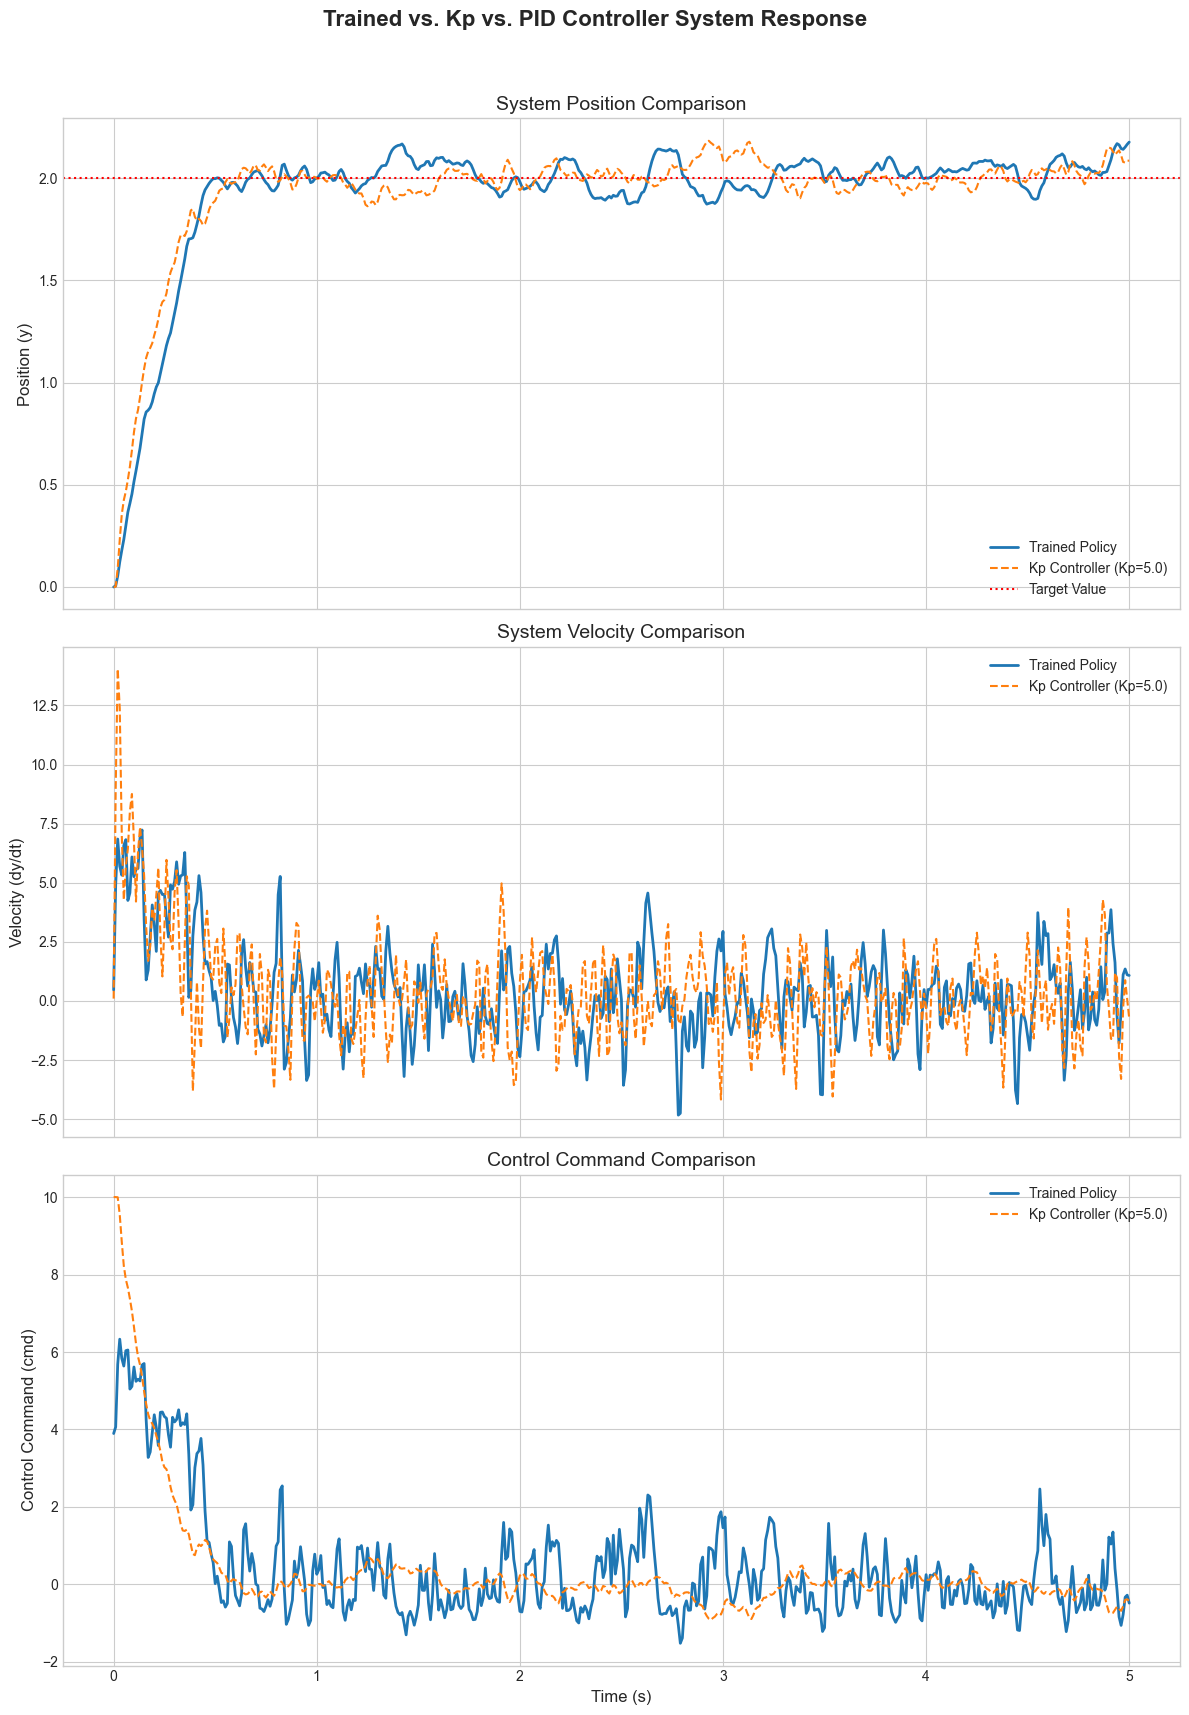

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR


# Define the ThirdOrderSystem as an nn.Module
class ThirdOrderSystem(nn.Module):
    def __init__(self, zeta, omega_n, noise_level: float = 1.0, sim_dt=0.01):
        super(ThirdOrderSystem, self).__init__()
        self.zeta = torch.tensor(zeta, dtype=torch.float32)
        self.omega_n = torch.tensor(omega_n, dtype=torch.float32)
        self.sim_dt = sim_dt
        # Detach the state to ensure it's treated as a leaf tensor in new graphs
        self.state = torch.zeros(3).detach()
        self.noise_level = noise_level

    def simulate(self, cmd):
        # Ensure cmd is a tensor
        if not isinstance(cmd, torch.Tensor):
            cmd = torch.tensor(cmd, dtype=torch.float32)

        # The state update logic should not be part of the graph being differentiated
        # in the training loop, so we can detach it.
        # This is especially important when re-using the class for simulation.
        current_state = self.state.detach()

        angle_next = current_state[0] + self.sim_dt * current_state[1]
        y, dy_dt = current_state[1], current_state[2]

        dy_dt2 = (
            -(self.omega_n**2) * y
            - 2 * self.zeta * self.omega_n * dy_dt
            + self.omega_n**2 * cmd
        )

        y_next = y + dy_dt * self.sim_dt + torch.randn(1).item() * self.noise_level
        dy_dt_next = dy_dt + dy_dt2 * self.sim_dt
        self.state = torch.stack([angle_next, y_next, dy_dt_next])
        return self.state


# Define the ControlPolicy as an nn.Module
class ControlPolicy(nn.Module):
    def __init__(self):
        super(ControlPolicy, self).__init__()
        self.control_net = nn.Sequential(
            nn.Linear(2, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 1),
        )

    def forward(self, target, current_state):
        error = target - current_state[0]
        velocity = current_state[1]
        # Input to the network: position error and velocity
        net_input = torch.stack([error, velocity])
        cmd = self.control_net(net_input)
        return cmd.squeeze()


# Simulation parameters
zeta_val = 0.8
omega_n_val = 100.0
target_value_train = torch.tensor(1.0)

# Instantiate models and optimizer
system = ThirdOrderSystem(zeta=zeta_val, omega_n=omega_n_val, noise_level=0.0)
policy = ControlPolicy()
optimizer = torch.optim.Adam(policy.parameters(), lr=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=0.0001)
# Training loop with BPTT
num_epochs = 500
rho1 = 1000.0  # Weight for position error
rho2 = 10000.0  # Weight for velocity squared
velocity_limit = 5.0  # Velocity limit for penalty
print("Starting training...")
for epoch in range(num_epochs):
    # Reset for each epoch
    system.state = torch.zeros(3)
    total_loss = 0
    optimizer.zero_grad()  # Clear gradients at the start of the epoch

    # BPTT loop - build computation graph over the trajectory
    trajectory_states = []
    cmds = []

    # Forward pass to collect trajectory
    temp_system_state = system.state.clone().detach()
    for _ in range(200):
        cmd = policy(target_value_train, temp_system_state)
        # Use a temporary system for forward pass to keep the graph clean
        # The system state update itself is a part of the computation graph
        angle_next = temp_system_state[0] + system.sim_dt * temp_system_state[1]
        y, dy_dt = temp_system_state[1], temp_system_state[2]
        dy_dt2 = (
            -(system.omega_n**2) * y
            - 2 * system.zeta * system.omega_n * dy_dt
            + system.omega_n**2 * cmd
        )
        y_next = y + dy_dt * system.sim_dt
        dy_dt_next = dy_dt + dy_dt2 * system.sim_dt
        temp_system_state = torch.stack([angle_next, y_next, dy_dt_next])
        trajectory_states.append(temp_system_state)

    # Calculate loss over the trajectory
    for i, state in enumerate(trajectory_states):
        if i > 30:
            error_y = (target_value_train - state[0]) ** 2
            total_loss += rho1 * error_y
        over_limit = torch.relu(torch.abs(state[1]) - velocity_limit)
        loss = rho2 * over_limit**2
        total_loss += loss

    total_loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss.item():.4f}")

print("Training finished.")


# Simulation and Plotting after Training
print("Simulating and plotting the final response...")

# Re-instantiate the systems to start from a clean state
system_final_trained = ThirdOrderSystem(
    zeta=zeta_val, omega_n=omega_n_val, noise_level=1.0
)
system_final_kp = ThirdOrderSystem(zeta=zeta_val, omega_n=omega_n_val, noise_level=1.0)


# Prepare lists to store data for plotting
positions_trained, positions_kp = [], []
velocities_trained, velocities_kp = [], []
commands_trained, commands_kp = [], []
time_points = []
time_step = 0.01
total_time = 5.0

# ---
# Controller parameters for comparison
# ---
# Kp controller
kp_gain = 5.0


target_value_sim = torch.tensor(2.0)
current_time = 0.0
while current_time <= total_time:
    with torch.no_grad():
        # 1. Trained policy
        cmd_trained = policy(target_value_sim, system_final_trained.state)

        # 2. Kp controller
        error_kp = target_value_sim - system_final_kp.state[0]
        cmd_kp = kp_gain * error_kp

    # Simulate the system's response for all three controllers
    system_final_trained.simulate(cmd_trained)
    system_final_kp.simulate(cmd_kp)

    # Record the data for plotting
    positions_trained.append(system_final_trained.state[0].item())
    positions_kp.append(system_final_kp.state[0].item())

    velocities_trained.append(system_final_trained.state[1].item())
    velocities_kp.append(system_final_kp.state[1].item())

    commands_trained.append(cmd_trained.item())
    commands_kp.append(cmd_kp.item())

    time_points.append(current_time)
    current_time += time_step

# Plotting the results
plt.style.use("seaborn-v0_8-whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
fig.suptitle(
    "Trained vs. Kp vs. PID Controller System Response",
    fontsize=16,
    fontweight="bold",
)

# --- Subplot 1: Position ---
ax1.set_ylabel("Position (y)", fontsize=12)
ax1.plot(
    time_points,
    positions_trained,
    color="tab:blue",
    label="Trained Policy",
    linewidth=2,
)
ax1.plot(
    time_points,
    positions_kp,
    color="tab:orange",
    linestyle="--",
    label=f"Kp Controller (Kp={kp_gain})",
)

ax1.axhline(y=target_value_sim.item(), color="r", linestyle=":", label="Target Value")
ax1.set_title("System Position Comparison", fontsize=14)
ax1.legend(loc="lower right")
ax1.grid(True)

# --- Subplot 2: Velocity ---
ax2.set_ylabel("Velocity (dy/dt)", fontsize=12)
ax2.plot(
    time_points,
    velocities_trained,
    color="tab:blue",
    label="Trained Policy",
    linewidth=2,
)
ax2.plot(
    time_points,
    velocities_kp,
    color="tab:orange",
    linestyle="--",
    label=f"Kp Controller (Kp={kp_gain})",
)
ax2.set_title("System Velocity Comparison", fontsize=14)
ax2.legend(loc="upper right")
ax2.grid(True)

# --- Subplot 3: Control Command ---
ax3.set_xlabel("Time (s)", fontsize=12)
ax3.set_ylabel("Control Command (cmd)", fontsize=12)
ax3.plot(
    time_points, commands_trained, color="tab:blue", label="Trained Policy", linewidth=2
)
ax3.plot(
    time_points,
    commands_kp,
    color="tab:orange",
    linestyle="--",
    label=f"Kp Controller (Kp={kp_gain})",
)

ax3.set_title("Control Command Comparison", fontsize=14)
ax3.legend(loc="upper right")
ax3.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig("third_order_system_comparison_full_with_pid.png")
plt.show()

Train on zeta = 0.8, test on different zeta

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os

# ---
# Define System and Controller Architectures
# ---


class ThirdOrderSystem(nn.Module):
    """Defines the third-order system dynamics."""

    def __init__(self, zeta, omega_n, sim_dt=0.01):
        super(ThirdOrderSystem, self).__init__()
        self.zeta = torch.tensor(zeta, dtype=torch.float32)
        self.omega_n = torch.tensor(omega_n, dtype=torch.float32)
        self.sim_dt = sim_dt
        self.state = torch.zeros(3).detach()

    def simulate(self, cmd):
        """Simulates one time step of the system."""
        if not isinstance(cmd, torch.Tensor):
            cmd = torch.tensor(cmd, dtype=torch.float32)

        # Detach state to prevent it from being part of the graph in subsequent steps
        current_state = self.state.detach()

        angle_next = current_state[0] + self.sim_dt * current_state[1]
        y, dy_dt = current_state[1], current_state[2]

        dy_dt2 = (
            -(self.omega_n**2) * y
            - 2 * self.zeta * self.omega_n * dy_dt
            + self.omega_n**2 * cmd
        )

        y_next = y + dy_dt * self.sim_dt
        dy_dt_next = dy_dt + dy_dt2 * self.sim_dt
        self.state = torch.stack([angle_next, y_next, dy_dt_next])
        return self.state


class ControlPolicy(nn.Module):
    """A simple neural network to act as a control policy."""

    def __init__(self):
        super(ControlPolicy, self).__init__()
        self.control_net = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
        )

    def forward(self, target, current_state):
        """Calculates control command based on target and current state."""
        error = target - current_state[0]
        velocity = current_state[1]
        net_input = torch.stack([error, velocity])
        cmd = self.control_net(net_input)
        return cmd.squeeze()


# ---
# Training Section
# ---

# Training parameters
zeta_train = 0.8
omega_n_train = 100.0
target_value_train = torch.tensor(1.0)
num_epochs = 500
rho1 = 1000.0  # Weight for position error
rho2 = 10000.0  # Weight for velocity penalty
velocity_limit = 5.0  # Velocity limit for penalty

# Instantiate models and optimizer
training_system = ThirdOrderSystem(zeta=zeta_train, omega_n=omega_n_train)
policy = ControlPolicy()
optimizer = torch.optim.Adam(policy.parameters(), lr=0.01)

print(f"Starting training on system with zeta={zeta_train}, omega_n={omega_n_train}...")
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Use a temporary state for building the computation graph
    temp_system_state = torch.zeros(3)
    trajectory_states = []

    # Forward pass over a time horizon to collect trajectory
    for _ in range(200):
        cmd = policy(target_value_train, temp_system_state)

        # Manually unroll the system dynamics to build the graph
        angle_next = (
            temp_system_state[0] + training_system.sim_dt * temp_system_state[1]
        )
        y, dy_dt = temp_system_state[1], temp_system_state[2]
        dy_dt2 = (
            -(training_system.omega_n**2) * y
            - 2 * training_system.zeta * training_system.omega_n * dy_dt
            + training_system.omega_n**2 * cmd
        )
        y_next = y + dy_dt * training_system.sim_dt
        dy_dt_next = dy_dt + dy_dt2 * training_system.sim_dt
        temp_system_state = torch.stack([angle_next, y_next, dy_dt_next])
        trajectory_states.append(temp_system_state)

    # Calculate loss over the entire trajectory
    total_loss = 0
    for i, state in enumerate(trajectory_states):
        if (
            i > 30
        ):  # Allow some time for the system to settle before calculating position error
            error_y = (target_value_train - state[0]) ** 2
            total_loss += rho1 * error_y

        over_limit = torch.relu(torch.abs(state[1]) - velocity_limit)
        velocity_penalty = rho2 * over_limit**2
        total_loss += velocity_penalty

    total_loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss.item():.4f}")

print("Training finished.")


# ---
# NEW: Simulation and Plotting Function for different scenarios
# ---
def run_and_plot_simulation(policy, test_zeta, test_omega_n, target_value_sim, kp_gain):
    """
    Simulates the trained policy and Kp controller for a given system
    and plots the results.
    """
    print(f"\n--- Running simulation for Zeta={test_zeta}, Omega_n={test_omega_n} ---")

    # Instantiate systems for this specific scenario
    system_trained = ThirdOrderSystem(zeta=test_zeta, omega_n=test_omega_n)
    system_kp = ThirdOrderSystem(zeta=test_zeta, omega_n=test_omega_n)

    # Data logging lists
    time_points = []
    positions_trained, velocities_trained, commands_trained = [], [], []
    positions_kp, velocities_kp, commands_kp = [], [], []

    current_time = 0.0
    total_time = 5.0

    while current_time <= total_time:
        with torch.no_grad():
            # 1. Trained policy
            cmd_trained = policy(target_value_sim, system_trained.state)

            # 2. Kp controller
            error_kp = target_value_sim - system_kp.state[0]
            cmd_kp = kp_gain * error_kp

        # Simulate one step for all systems
        system_trained.simulate(cmd_trained)
        system_kp.simulate(cmd_kp)

        # Record data
        time_points.append(current_time)
        positions_trained.append(system_trained.state[0].item())
        velocities_trained.append(system_trained.state[1].item())
        commands_trained.append(cmd_trained.item())
        positions_kp.append(system_kp.state[0].item())
        velocities_kp.append(system_kp.state[1].item())
        commands_kp.append(cmd_kp.item())

        current_time += system_trained.sim_dt

    # Plotting
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
    fig.suptitle(
        f"Controller Response for Zeta={test_zeta}, Omega_n={test_omega_n}\n"
        f"(Trained on Zeta={zeta_train}, Omega_n={omega_n_train})",
        fontsize=16,
        fontweight="bold",
    )

    # Plot Position
    ax1.plot(time_points, positions_trained, label="Trained Policy", linewidth=2)
    ax1.plot(
        time_points, positions_kp, label=f"Kp Controller (Kp={kp_gain})", linestyle="--"
    )
    ax1.axhline(y=target_value_sim.item(), color="r", linestyle=":", label="Target")
    ax1.set_title("System Position Comparison", fontsize=14)
    ax1.set_ylabel("Position", fontsize=12)
    ax1.legend()
    ax1.grid(True)

    # Plot Velocity
    ax2.plot(time_points, velocities_trained, label="Trained Policy", linewidth=2)
    ax2.plot(time_points, velocities_kp, label="Kp Controller", linestyle="--")
    ax2.set_title("System Velocity Comparison", fontsize=14)
    ax2.set_ylabel("Velocity", fontsize=12)
    ax2.legend()
    ax2.grid(True)

    # Plot Command
    ax3.plot(time_points, commands_trained, label="Trained Policy", linewidth=2)
    ax3.plot(time_points, commands_kp, label="Kp Controller", linestyle="--")
    ax3.set_title("Control Command Comparison", fontsize=14)
    ax3.set_xlabel("Time (s)", fontsize=12)
    ax3.set_ylabel("Command", fontsize=12)
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Create a directory to save plots if it doesn't exist
    if not os.path.exists("simulation_results"):
        os.makedirs("simulation_results")

    filename = (
        f"simulation_results/comparison_zeta_{test_zeta}_omega_{test_omega_n}.png"
    )
    plt.savefig(filename)
    print(f"Plot saved to {filename}")
    plt.close(fig)  # Close the figure to free up memory


# ---
# Define Test Scenarios and Run Simulations
# ---
target_value_sim = torch.tensor(2.0)
kp_gain = 5.0

# Define the different system dynamics to test
test_scenarios = [
    # 1. The system it was trained on (baseline)
    {"zeta": zeta_train, "omega_n": omega_n_train},
    # 2. Lower damping (more oscillatory)
    {"zeta": 0.4, "omega_n": omega_n_train},
    {"zeta": 0.5, "omega_n": omega_n_train},
    {"zeta": 0.6, "omega_n": omega_n_train},
    {"zeta": 0.7, "omega_n": omega_n_train},
    # 3. Higher damping (slower response)
    {"zeta": 0.9, "omega_n": omega_n_train},
    {"zeta": 1.0, "omega_n": omega_n_train},
    {"zeta": 1.1, "omega_n": omega_n_train},
]

# Run simulation and plotting for each scenario
for scenario in test_scenarios:
    run_and_plot_simulation(
        policy,
        test_zeta=scenario["zeta"],
        test_omega_n=scenario["omega_n"],
        target_value_sim=target_value_sim,
        kp_gain=kp_gain,
    )

print(
    "\nAll simulations are complete. Check the 'simulation_results' folder for the plots."
)